In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
wine_type_df = pd.read_csv('winequalityN.csv')
wine_type_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


В данной лабораторной работе будут сравниваться алгоритмы кластеризации на таргетной переменной *type*, поэтому признак качества *quality*, удаляем из набора данных:

In [3]:
wine_type_df.drop(columns=['quality'], inplace=True)

Посмотрим на размер набора данных и количество наблюдений для белого и красного вина:

In [4]:
wine_type_df.shape

(6497, 12)

In [5]:
wine_type_df.type.value_counts()

white    4898
red      1599
Name: type, dtype: int64

Присутствует дисбаланс, для белого вина кол-во наблюдений превышает в три раза. 

Посмотрим на кол-во пропущенных значений в наборе данных:

In [6]:
wine_type_df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
dtype: int64

Перед тем, как заполнять данные пропущенные значения, определим выбросы в распределениях признаков, с последующей заменой шумных значений на пропуски. В таком случае появляется возможность сохранить первоначальный объем набора данных, исключив из него выбросы.

Выбросы будут определяться по попаданию или не попаданию в интервал [Q1 - 1.5*IQR, Q3 + 1.5*IQR], также, фильтрация данных будет осущствляться для выборок предварительно разделенных по типу вина, то есть для красного и белого вина раздельно.

Построим графики boxplot:

In [7]:
chemical_feats = wine_type_df.columns.to_list()
chemical_feats.remove('type')

	Графики boxplot для признаков набора данных в зависимости от типа вина:


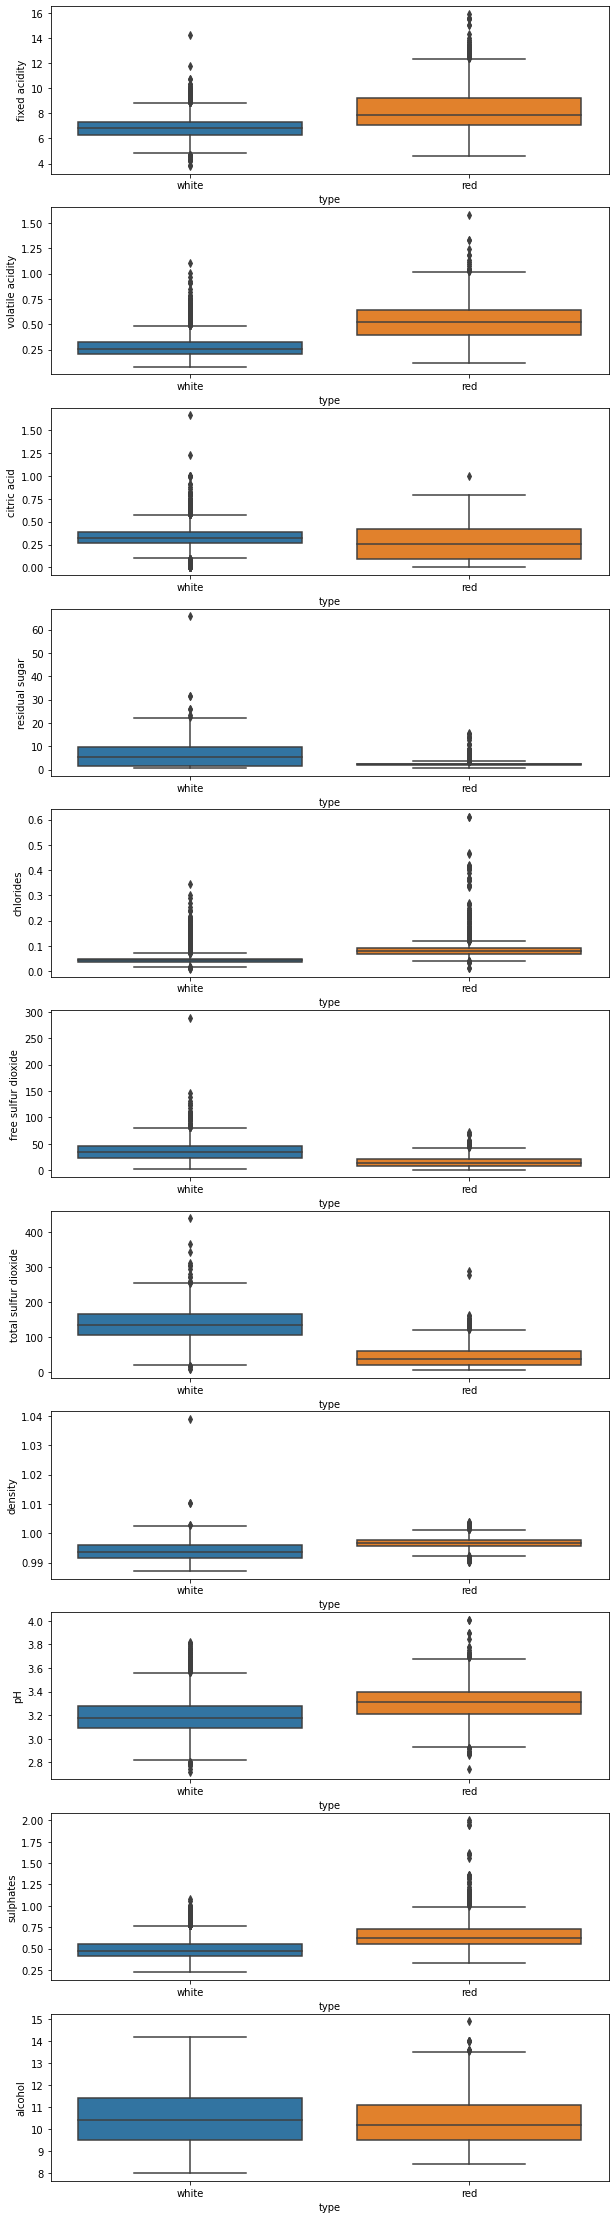

In [8]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,40))
print('\tГрафики boxplot для признаков набора данных в зависимости от типа вина:')
for i, feat in enumerate(chemical_feats):
     sns.boxplot(y=wine_type_df[feat], x=wine_type_df['type'], ax=axs[i])

Осуществляем фильтрацию данных, то есть назначение не попавшим в интервал наблюдениям значения NaN: 

In [9]:
for wine_type in ['white', 'red']:
    for column in chemical_feats:
        Q1 = wine_type_df.loc[wine_type_df['type']==wine_type, column].quantile(0.25)
        Q3 = wine_type_df.loc[wine_type_df['type']==wine_type, column].quantile(0.75)
        IQR = Q3 - Q1
        filter_cond = ((wine_type_df[column]<(Q1 - 1.5*IQR))| (wine_type_df[column]>(Q3 + 1.5*IQR)))
        wine_type_df.loc[(wine_type_df['type']==wine_type)&(filter_cond),column] = np.nan 

Ещё раз построим boxplot'ы и проверим, что фильтрация прошла успешно:

	Графики boxplot для признаков набора данных в зависимости от типа вина:


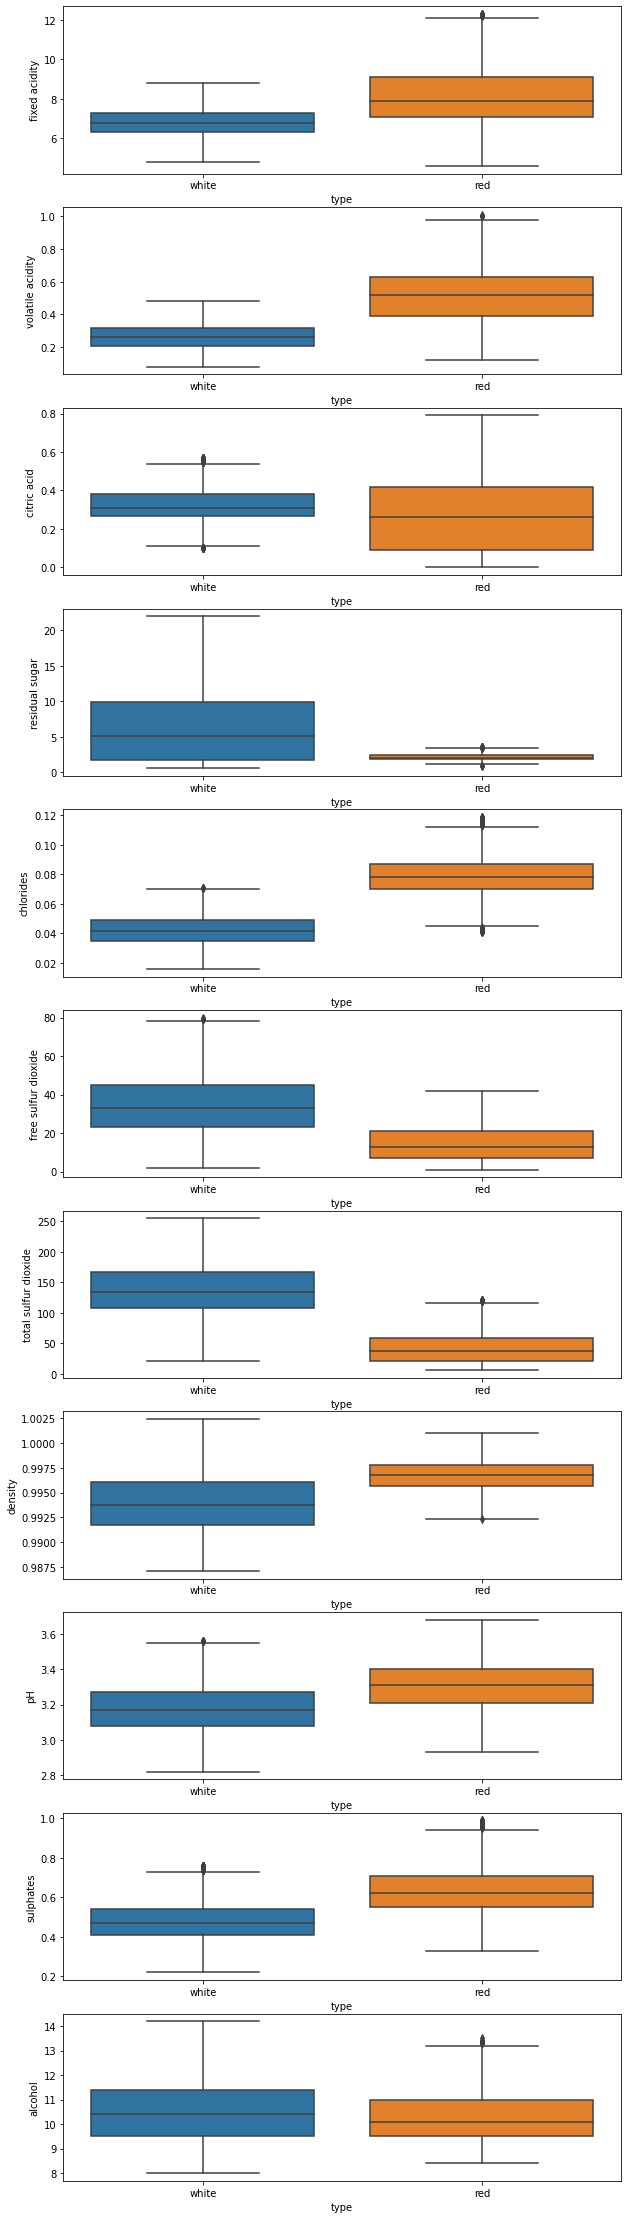

In [10]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,40))
print('\tГрафики boxplot для признаков набора данных в зависимости от типа вина:')
for i, feat in enumerate(chemical_feats):
     sns.boxplot(y=wine_type_df[feat], x=wine_type_df['type'], ax=axs[i])

Заменим пропущенные значения соответствующими медианными значениями выборки признака в зависимости от типа вина:

In [11]:
for wine_type in ['white', 'red']:
    wine_type_df[wine_type_df['type']==wine_type] = wine_type_df[wine_type_df['type']==wine_type]. \
                                        fillna(wine_type_df[wine_type_df['type']==wine_type].median())

In [12]:
wine_type_df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Пропущенных значений не осталось.

В первичном анализе построим графики медианных значений признаков в зависимости от типа вина с указанием дов. интервалов значений, данные значения были получены методом bootstrap'а. 

	Медианные значения хим. параметров вин с дов. интервалами в зависимости от типа вина:


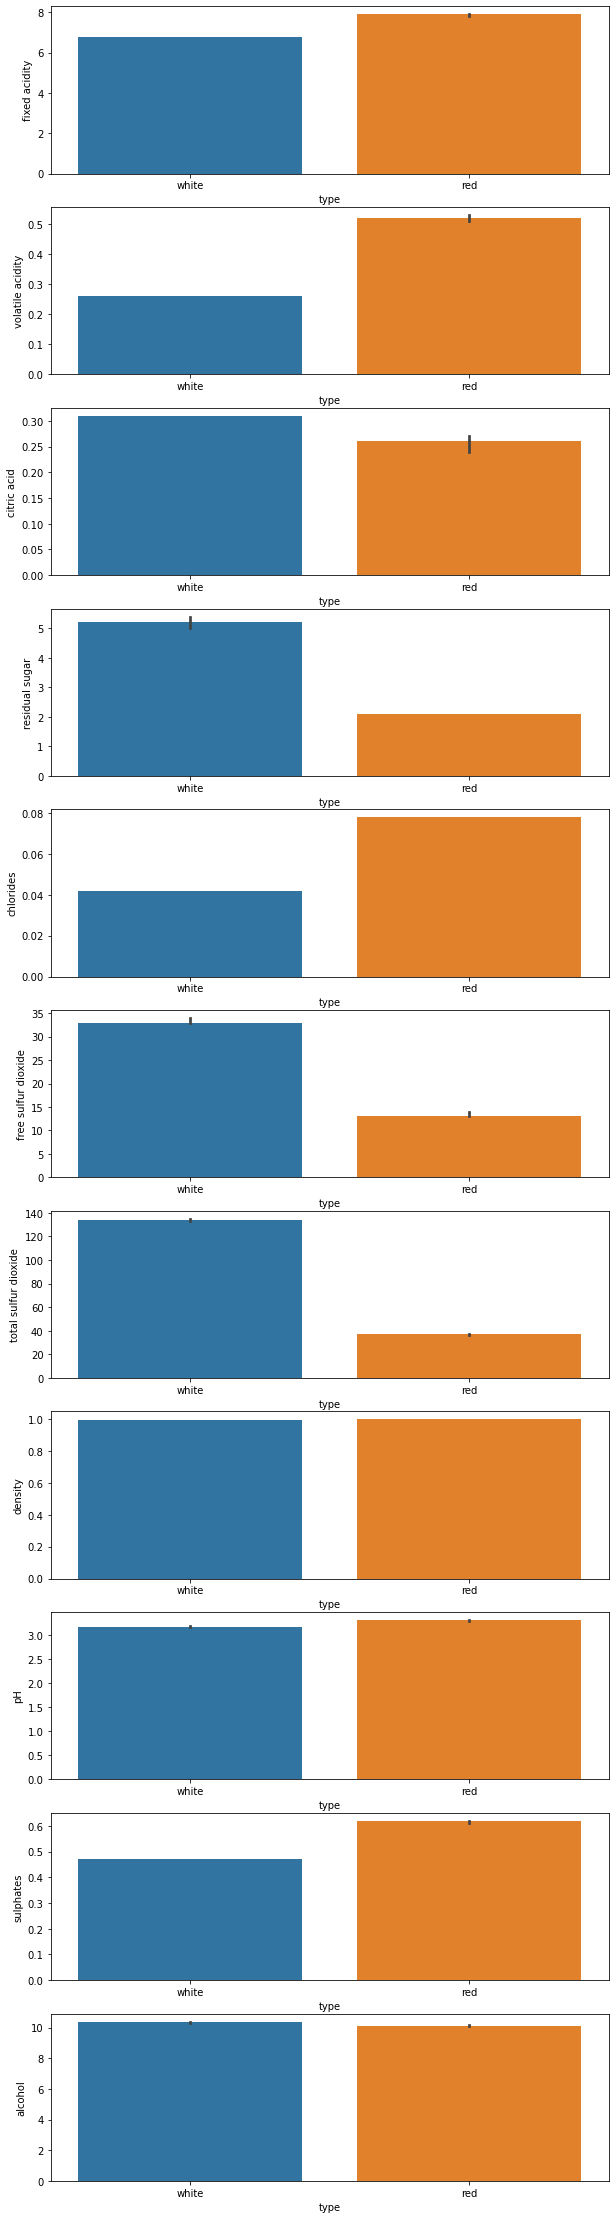

In [13]:
_, axs = plt.subplots(len(chemical_feats), figsize=(10,40))
print('\tМедианные значения хим. параметров вин с дов. интервалами в зависимости от типа вина:')
for i, feat in enumerate(chemical_feats):
    sns.barplot(y=wine_type_df[feat], x=wine_type_df['type'], estimator=np.median, ax=axs[i])

Можем пронаблюдать стат. значимые различия в медианных значениях признаков почти везде, кроме плотности (*density*), крепости (*alcohol*) и кислотности (*ph*) по водородной шкале алкоголя,


Построим гистограммы распределения признаков для каждого типа вина, так как классы несбалансированны, то распределение будет строится по *n_sample* случайно взятым наблюдениям, где *n_sample* - это кол-во наблюдений у минимально представленного класса:

	 Гистограммы распределения признаков в зависимости от типа вина:


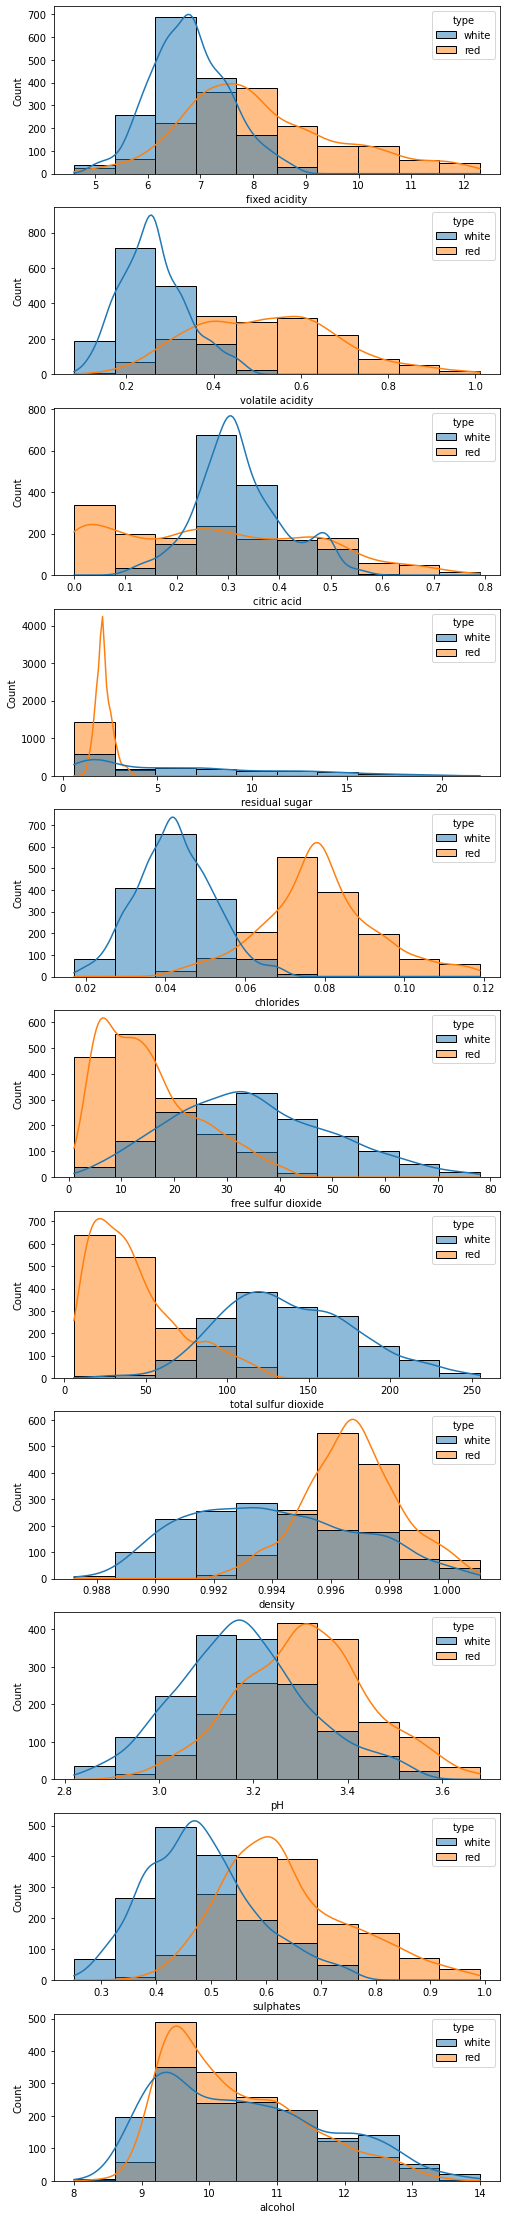

In [14]:
_, axs = plt.subplots(len(chemical_feats), figsize=(8,40))
n_sample = wine_type_df.type.value_counts()[1]
print('\t Гистограммы распределения признаков в зависимости от типа вина:')
for i, feat in enumerate(chemical_feats):
    df1 = wine_type_df.loc[wine_type_df.type=='white',[feat, 'type']].sample(n=n_sample, random_state=42)
    df2 = wine_type_df.loc[wine_type_df.type=='red',[feat, 'type']].sample(n=n_sample, random_state=42)

    df = pd.concat([df1, df2],
                   ignore_index=True)
          

    sns.histplot(x=df[feat], hue=df['type'], kde=True, ax=axs[i], bins=10)

Проанализируем получившиеся распределения.

*fixed acidity*:
    - Для фиксированной кислотности получили два нормальных распределения, при этом у распределения красного вина присутствует большой хвост справа. Также, хоть средние выборок различаются, распределения, особенно распределение для красного вина, имеет большую дисперсию, что приводит к тому, что выборки довольно сильно смешаны между собой, это отрицательно сказывается на кластеризации.
    
*volatile acidity*:
    - Для летучей кислотности имеем нормальное распределение и среднии различаются, но, аналогично с фиксированной кислотностью, красные вина имеют очень большую дисперсию.

*citric acid*:
    - Для лимонной кислоты имеем норм. распределение у белых вин и зашумленное логнормальное для красных, это немного странная ситуация, когда большое кол-во вин имеют лимонную кислотность близкую к нулю, не уверен, но кажется, что значения меньше 0,1 для красных вин, не соответствуют действительности, так как лимонная кислота хоть и не в большом кол-ве, но все таки присутствует во всех винах.

*residual sugar*:
    - Для остаточного сахара предположительно имеем ооочень длинный хвост справа для белого вина, построим аналогичную гистограмму, профильтровав предварительно значения сахара < 4:


3675
white    2076
red      1599
Name: type, dtype: int64


<AxesSubplot:xlabel='residual sugar', ylabel='Count'>

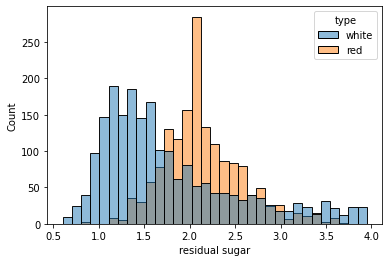

In [15]:
test = wine_type_df.copy()
test = test[test['residual sugar'] < 4].copy()
print(test.shape[0])
print(test.type.value_counts())
sns.histplot(x=test['residual sugar'], hue=test.type)


Видим, что количество наблюдений для белого вина уменьшлось практически в два раза, а количество наблюдений у красного не изменилось. 

Построенная гистограмма на самом деле соответствует гистограммам распределения для сухих вин, длинный хвост был смешением нормальных распределений для различных сортов вина:
  сухие (до 4-ех г/л),
  полусухие (от 4-ех до 18-ти г/л),
  полусладкие (от 18-ти до 45 г/л)
  сладкие (больше 45 г/л)

На гистограммах для сухих вин видим, что средние различины, но опять дисперсия будет виной плохой работы алгротимов кластеризации, тем более, что красные и белые вина представлены в различном кол-ве сортов (для красных есть только сухие вина)

Удалим из выборки белые вина с концентрацией сахар больше 4-ех г/л, этим мы очень сильно выравниваем баланс по цвету вина и убираем дисбаланс по сорту вина, так как у красных вин присутствуют только сухие вина в выборке:

In [16]:
wine_type_df = wine_type_df[wine_type_df['residual sugar'] < 4].reset_index(drop=True).copy()


*chlorides*:
    
    - Концентрация хлоридов имеет нормальное распределение для каждого из типов вин, при этом смешение распределений не большое, что дает основания предполагать, что данный признак хорошо разделяет выборки. 
 
*free sulfur dioxide*:
    - Концентрация свободного диоксида серы имеет скорее распределение хи-квадрат, проверим это, построив распределение от корня кадратного значения концентрации:

<AxesSubplot:xlabel='sqrt free sulfur dioxide', ylabel='Count'>

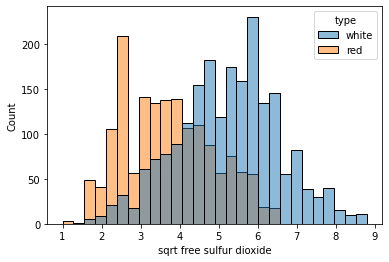

In [17]:
wine_type_df['sqrt free sulfur dioxide'] = np.sqrt(wine_type_df['free sulfur dioxide'])
sns.histplot(x=wine_type_df['sqrt free sulfur dioxide'], hue=wine_type_df.type)

Получившиеся распределения ближе к нормальному, но проблема сильного смешивания тут также остра

*total sulfur dioxide*:
    - Имеет схожее с концентрацией свободных диоксидов серы распределение, что понятно, так как общая концентрация диоксидов серы включает в себя концентрацию свободных диоксидов. Также возьмем корень квадратный из величины:

<AxesSubplot:xlabel='sqrt total sulfur dioxide', ylabel='Count'>

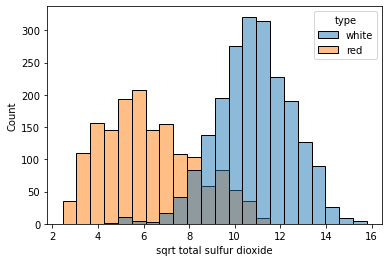

In [18]:
wine_type_df['sqrt total sulfur dioxide'] = np.sqrt(wine_type_df['total sulfur dioxide'])
sns.histplot(x=wine_type_df['sqrt total sulfur dioxide'], hue=wine_type_df.type)

Помимо того, что распределения также стали нормальными, наблюдаем не сильную смесь гауссиан, что дает основание считать этот признак полезным для кластеризования.

*density*:

<AxesSubplot:xlabel='density', ylabel='Count'>

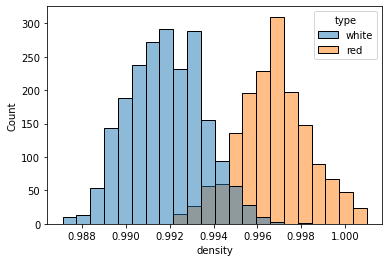

In [19]:
sns.histplot(x=wine_type_df['density'], hue=wine_type_df.type)

Плотность вина после того, как в наборе данных были оставлены только сухие белые вина, стала иметь нормальное распределение для белых вин с небольшой дисперсией и смешением двух распределений, что делает данный признак полезным для алгоритмов кластеризации.

*pH*:

<AxesSubplot:xlabel='pH', ylabel='Count'>

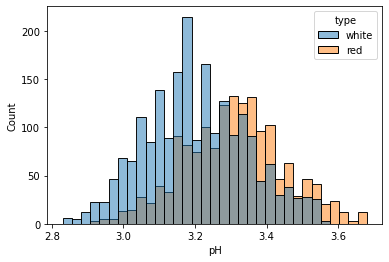

In [20]:
sns.histplot(x=wine_type_df['pH'], hue=wine_type_df.type)

Распределения кислотности по водородной шкале хоть и имеют нормальное распределение и различные средние выборок, но также имеют большое смешение распределений и большую дисперсию, что делает этот признак не валидным для кластеризации.

*sulphates*:

    - Для концентрации минеральных солей ситуация аналогична предыдущему признаку:

<AxesSubplot:xlabel='sulphates', ylabel='Count'>

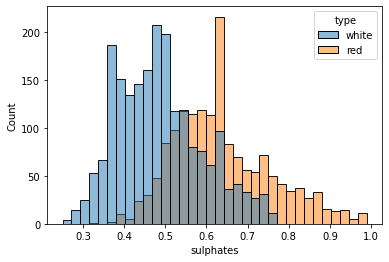

In [21]:
sns.histplot(x=wine_type_df['sulphates'], hue=wine_type_df.type)

*alcohol*:

    - Крепость алкоголя также не дает оснований выбрать данный признак для использования в задаче кластеризации.

<AxesSubplot:xlabel='alcohol', ylabel='Count'>

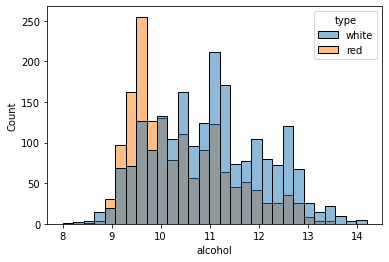

In [22]:
sns.histplot(x=wine_type_df['alcohol'], hue=wine_type_df.type)

Возьмем для дальнейшей работы признаки *sqrt total sulfur dioxide*, *density* и *chlorides*, нормализуем их и построим диагрмму рассеивания:

In [23]:
from sklearn import preprocessing

sign_feats = ['sqrt total sulfur dioxide', 'density', 'chlorides']

stand_transformer = preprocessing.StandardScaler()
stand_transf = stand_transformer.fit_transform(wine_type_df.loc[:, sign_feats])

stand_df = pd.DataFrame(stand_transf, columns=sign_feats)
stand_df['type'] = wine_type_df['type'].copy()

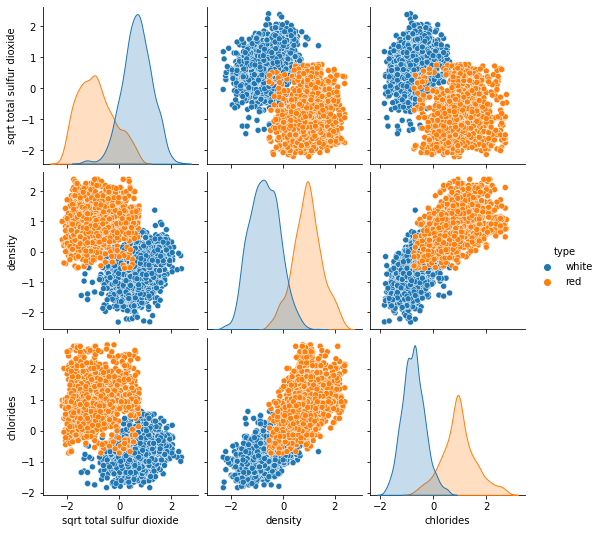

In [24]:
sns.pairplot(stand_df, hue='type')

Можно заметить, что пары признаков *sqrt total sulfur dioxide*/*density* и *sqrt total sulfur dioxide*/*chlorides* дают наиболее заметные разбиения выборок по типу вина. В целом, должны работать хорошо и алгоритмы, основывающиеся на расстояниях, и основывающиеся на плотностях алгоритмы.

Сформируем вектор признаков *X* и вектор истинных меток класса *y*, у *y* заменим красное и белое вино на числа 0 и 1, соответственно.

In [25]:
X = stand_df.drop(columns=['type']).copy()
y = stand_df.type.copy()

y.replace({'red': 0, 'white': 1}, inplace=True) 

Функция для расчета среднего попарного внутрикластерного и межкластерного расстояния:

In [26]:
import functools
from sklearn.metrics import pairwise_distances_chunked
from sklearn.metrics.cluster._unsupervised import _silhouette_reduce

def clust_dist(X, labels, *, metric='euclidean', **kwds):
    
    label_freqs = np.bincount(labels)
    reduce_func = functools.partial(_silhouette_reduce,
                                    labels=labels, label_freqs=label_freqs)
    results = zip(*pairwise_distances_chunked(X, reduce_func=reduce_func,
                                              **kwds))
    intra_clust_dists, inter_clust_dists = results
    intra_clust_dists = np.concatenate(intra_clust_dists)
    inter_clust_dists = np.concatenate(inter_clust_dists)
    
    # Взвешиваем внутрикласторные расстояния по частоте кластера-1 в соотв. кластерах
    denom = (label_freqs - 1).take(labels, mode='clip')
    with np.errstate(divide="ignore", invalid="ignore"):
        intra_clust_dists /= denom
        
    intra_clust_dists = np.nan_to_num(intra_clust_dists)
    inter_clust_dists = np.nan_to_num(inter_clust_dists)
    
    # Определяем среднее значения для внутрикластерного и межкластерного расстояний и возвращаем их:
    return np.mean(intra_clust_dists), np.mean(inter_clust_dists)

Функция, которая на вход берет матрицу признаков, истинных меток объектов и словарь с моделями кластеризации. В данной функции происходит кластеризация данных каждой из моделей в словаре, расчет времени, затраченного на кластеризацию данных, расчет метрик, создание таблицы, содержащей истинные метки объектов и метки, присвоенные объектам каждой из моделей.

In [82]:
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score, davies_bouldin_score
from sklearn import cluster
from timeit import default_timer as timer


def test_clust_est(X, y, est_dict):
    
    clust_lbl_df = pd.DataFrame()
    clust_lbl_df['labels'] = y.values
    
    for cluster_alg in est_dict.keys():
        print(f'============ Cluster algorithm: {cluster_alg} ============\n')
        t_start = timer()
        est = est_dict[cluster_alg]
        labels_pred = est.fit_predict(X, y)
        t_stop = timer()
        print("time: {:.4f}s\n".format(t_stop-t_start))
        
        clust_lbl_df[f'{cluster_alg}_labels'] = labels_pred
        
        # игнорируем метки шума алгоритма DBSCAN 
        X_feat = X.loc[~(labels_pred == -1), : ].copy()
        labels_true = y[labels_pred!=-1].copy()
        labels_pred = labels_pred[np.where(labels_pred!=-1)]
        n_clusters_ = len(set(labels_pred))
        
        #n_clusters_ = len(set(labels_pred))- (1 if -1 in labels_pred else 0)
        print('Amount of clusters:', n_clusters_,'\n')
        
        
        
        if n_clusters_ == 1:
            continue
            
        print(f'Adjusted rand score: {adjusted_rand_score(labels_true, labels_pred)}\n')
        print(f'Intra- and inter-cluster distance:{clust_dist(X_feat, labels_pred)}\n')
        print(f'V_measure score: {v_measure_score(labels_true, labels_pred)}\n')
        print(f'Silhouette score: {silhouette_score(X_feat, labels_pred)}\n')
        print(f'Davies-Bouldin score: {davies_bouldin_score(X_feat, labels_pred)}\n')
        
    return clust_lbl_df


    Для оценки качества работы алгоритмов были выбраны метрики:

   - *Adjusted rand index*: данная метрика в упрощенном варианте (*Rand index*) представляет из себя аналог точности для пар предсказанных и истинных меток, версия *Adjusted* центрирует или корректирует оценку по нулю, то есть гарантирует значение 0 для случайной кластеризации, оценку 1 для идентичной истинной кластеризации, также значения метрики могут быть меньше нуля.
    
   - *Intra-* и * Inter-cluster distance*: внутре- и межкластерные расстояния, данные метрики не нормируются в определенном диапазоне, но превышение межкластерного расстояния внутрикластерного расстояния может для определенных невложенных кластеров (как в нашем случае) являться признаком верной кластеризации или хотя бы приближенной к верной.
    
   - *V measure score*: *V мера* является удвоенным произведением однородности на полноту, деленное на сумму однородности и полноты, при параметре бетта=1. Однородность в кластере принимает своё максимальное значение (равное 1), когда все точки кластера имеют истинные метки одного класса, полнота наоборот принимает максимальное значение (1), когда все точки истинного класса, попадают в один кластер, тогда границей *V меры* также является диапазон [0, 1].
    
   - *Silhouette score*: является объедененной оценкой внутре- и межкластерного расстояний, который вычисляется как их разница, деленное на максимальное значение, то есть нормированное по диапазону [-1, 1], тогда отрицательная область будет соответствовать неправильной кластеризации, область положительных значений - правильной, а область около нуля - смешанной кластеризации. В нашем случае значение 1 недостижимо, так как кластеры сами по себе имеют ненулевую дисперсию, расчитаем заранее максимальное значение этой метрики для нашего набора данных:
    
   

In [34]:
silhouette_score(X, y)

0.5759127849352843

Случайные метки для двух кластеров в среднем дадут следующее значение *Silhouette score*:

In [58]:
from random import randrange

mean_silhouette_score = 0
for j in range(100):
    mean_silhouette_score+= silhouette_score(X, [randrange(0, 2, 1) for i in range(len(y))])
    
mean_silhouette_score/100

-3.449276974466077e-05

Ориентируясь на данное значение можно оценить, насколько алгоритм приближен к идеальному разбиению выборки. Минимальное же значение при количестве кластеров, равном двух, то есть истинному, будет находиться в районе нуля.

- *Davies-Bouldin score*:  данная метрика является отношением суммы диаметров двух максимально схожих классов к расстоянию между их центроидами, чем меньше значение метрики, тем лучше произведено разбиение двух этих выборок, для количества кластеров более 2-ух, находится среднее значение метрики. Расчитаем максимальное значение данной метрики для нашего набора данных: 

In [84]:
davies_bouldin_score(X, y)

0.6360349141318596

В функции обучения и валидации наших алгоритмов перед расчетом метрик качества работы алгоритмов проводится очистка предсказанных и истинных меток от значений, лежащих по индексу значений -1 в предсказанном DBSCAN списке меток. Это происходит для того, чтобы метрики не воспринимали объекты, определенные DBSCAN как шумные, метками какого-то нового кластера. Данная фильтрация позволит определить, насколько оптимальна фильтрация алгоритмом относительно метрик качества. Но перед этим определим такие гиперпараметры алгоритма, которые на выходе дают кол-во класетров, равное двум. Основные гиперпараметры алгоритма - это *eps* и *min_samples*, которые определяют основную точку в алгоритме DBSCAN, как точку, имеющую в радиусе *eps*, как минимум *min_samples* точек. Параметр *eps*, помимо этого, влияет на достижимость основных и неосновных точек, это напрямую влияет на способность основных точек объединяться в кластеры. Также, меньшие значения способоствуют увеличению шумных точек, как и увеличение *min_samples*, при максимизации данных значений кластерами смогут стать только очень плотные и многочисленные скопления точек, поэтому также расчитаем отношение шумных точек ко всем точкам набора данных, чтобы выбрать значение, балансирующее между данными параметрами.

2 clusters: eps=0.35, min_samples=5, %noise=1.96
2 clusters: eps=0.35, min_samples=15, %noise=7.76
2 clusters: eps=0.40, min_samples=15, %noise=3.54
2 clusters: eps=0.30, min_samples=20, %noise=18.34
2 clusters: eps=0.40, min_samples=20, %noise=5.41
2 clusters: eps=0.45, min_samples=20, %noise=2.69
2 clusters: eps=0.25, min_samples=25, %noise=40.95
2 clusters: eps=0.30, min_samples=25, %noise=23.70
2 clusters: eps=0.35, min_samples=25, %noise=12.98
2 clusters: eps=0.40, min_samples=25, %noise=8.19
2 clusters: eps=0.45, min_samples=25, %noise=3.73


<AxesSubplot:>

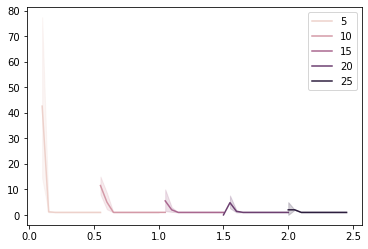

In [103]:
n_clusters_list = []
eps_list = np.arange(0.1, 2.5, 0.05)
min_samples_list = np.arange(5, 26, 5)
for min_samples in min_samples_list:
    for eps in eps_list:
        estimator = cluster.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels_pred = estimator.fit_predict(X, y)
        n_clusters_ = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
        n_clusters_list.append(n_clusters_)
        
        n_noise = np.count_nonzero(labels_pred == -1)
        if n_clusters_ == 2:
            print(f'2 clusters: eps={eps:.2f}, min_samples={min_samples}, %noise={(n_noise/len(labels_pred))*100:.2f}')
            
sns.lineplot(x=eps_list.repeat(len(min_samples_list)), y=n_clusters_list, hue=min_samples_list.repeat(len(eps_list)))

Наиболее оптимальным видится вектор параметров: eps=0.35, min_samples=15, %noise=7.76, который содержит относительно небольшое значение *eps* и кол-во шумных объектов (до 10% и больше 5%).

Помимо алгоритмов *K-means* и *DBSCAN*, также обучим алгоритм *MeanShift*, позволяющий кластеризовывать данные на основе функции ядра плотности, то есть успешное разбиение нашей выборки на два кластера позволит сделать вывод, что данные действительно представляют из себя два облака точек, имеющих относительно высокую плотность и достаточно разделенных в пространстве признаков. И алгоритм *Agglomerative Clustering* - иерархический алгоритм кластеризации, который на основе некоторой эвристики (в нашем случае это будет минимизация дисперсий кластеров - *ward*) производит объединение кластеров до достижения необходимого количества кластеров или порогового значения функции объединения кластеров.

In [98]:
estimators = {'K-means': cluster.KMeans(n_clusters=2, random_state=42),
              'MeanShift': cluster.MeanShift(n_jobs=-1),
              'DBSCAN': cluster.DBSCAN(n_jobs=-1, eps=0.35, min_samples=15),
              'Agglomerative Clustering': cluster.AgglomerativeClustering(n_clusters=2)}

In [99]:
norm_clust_lbls = test_clust_est(X, y, estimators)

============ Cluster algorithm: K-means ============

time: 0.0462s

Amount of clusters: 2 

Adjusted rand score: 0.9547805283925018

Intra- and inter-cluster distance:(1.258888191998423, 3.119934458051259)

V_measure score: 0.9122064632269306

Silhouette score: 0.5850009708176989

Davies-Bouldin score: 0.6255197686988536

============ Cluster algorithm: MeanShift ============

time: 5.6636s

Amount of clusters: 2 

Adjusted rand score: 0.959042521530024

Intra- and inter-cluster distance:(1.2588440716266018, 3.1190013488096597)

V_measure score: 0.9186495582320269

Silhouette score: 0.5848744126066056

Davies-Bouldin score: 0.6258187486369821

============ Cluster algorithm: DBSCAN ============

time: 0.0338s

Amount of clusters: 2 

Adjusted rand score: 0.9671883700067271

Intra- and inter-cluster distance:(1.1631271403019663, 3.071536982709162)

V_measure score: 0.9321744457601637

Silhouette score: 0.6111949172009701

Davies-Bouldin score: 0.583066955845507

============ Cluster al

Перед анализом результатов отобразим кластеризацию каждого из рассматриваемых алгоритмов на диаграмме рассеивания признаков концентрации хлоридов и корня кв. из общей концентрации сульфатов: 

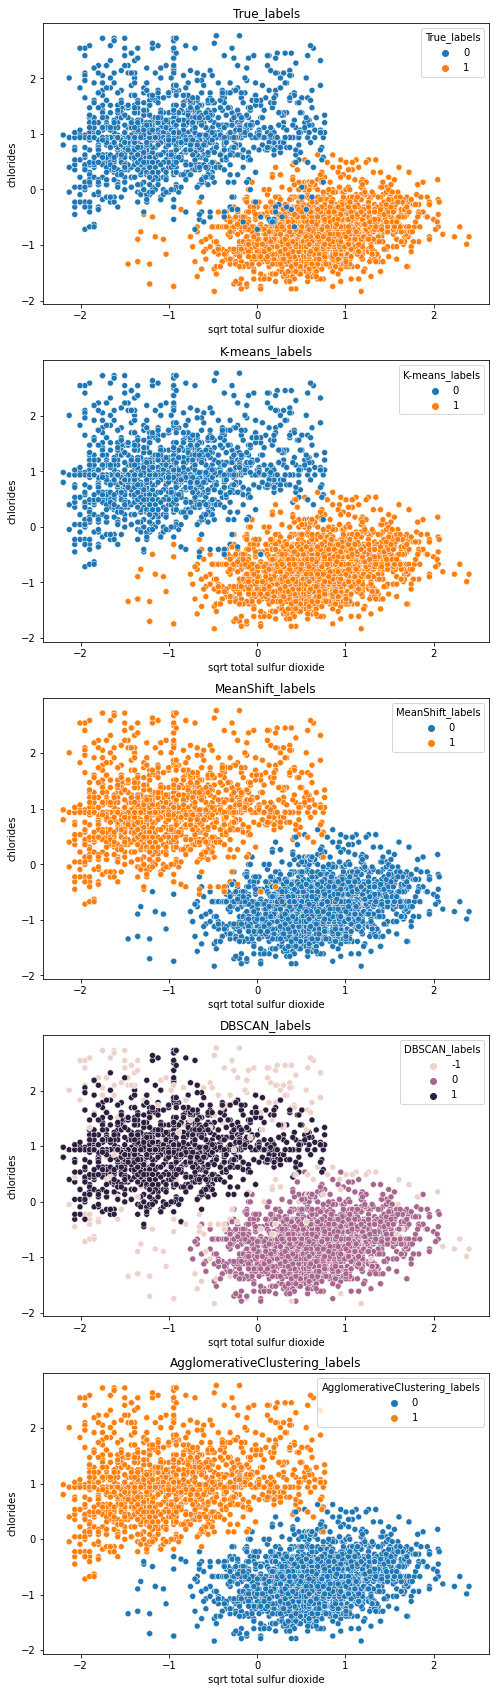

In [102]:
_, axs = plt.subplots(norm_clust_lbls.shape[1], figsize=(8,30))

norm_clust_lbls.rename(columns={'labels': 'True_labels'}, inplace=True)
for i, label in enumerate(norm_clust_lbls.columns):
    sns.scatterplot(x=X['sqrt total sulfur dioxide'], y=X['chlorides'], hue=norm_clust_lbls[label], ax=axs[i])
    axs[i].set_title(f'{label}')

   По метрикам качества естественным образом впереди оказался алгоритм *DBSCAN*, так как выбранный набор гиперпарамтеров позволил уменьшить дисперсию выборок, поэтому сравнивать его по метрикам качества кластеризации с остальными алгоритмами не имеет большого смысла. Но данный алгоритм можно эффективно использовать в качестве фильтрации наших данных перед последующим использованием, данную задачу, судя по диаграммам рассеивания, алгоритм выполняет вполне корректно, при этом, время кластеризации на данном наборе данных оказалось минимальным относительно остальных алгоритмов.

   Среди остальных алгоритмов лучшие показатели в среднем продемонстрировал *MeanShift*, при этом, на вход не подавлось кол-во кластеров. Это можно объяснить тем, что признаки, выбираемые для дальнейшей кластеризации, подбирались таким образом, чтобы распределения выборок этих признаков в зависимости от типа вина были, во-первых, нормально распределены, во-вторых, имели малую площадь смешения, такие выборки наиболее приближены к данным, для которых *MeanShift* был создан. Используя гауссово ядро алгоритм итеративно сходится по нашим двум нормальным распределениям к их модам, то есть средним, выполняя кластеризацию на очень высоком уровне. Но минусом данного алгоритма является время его работы, оно примерно в сто раз больше времени работы алгоритма *K-means*, что очень ощутимо. 
    
   Алгоритмы *K-means* и *Agglomerative Clustering* тоже показали относительно высокие результаты, но время работы алгоритма *K-means* меньше почти в 10 раз, что делает его более предпочтительным в использовании.